In [1]:
%matplotlib inline
import requests
from datetime import datetime
from matplotlib import pyplot as plt
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numba import guvectorize
from scipy import signal
from scipy import stats as ss

# utils functions
# ===============

def get_prices(coin_symbol):
    """Get close price.

    Given a symbol crytocurrency retrieve last 2k close prices in USD.

    Parameters
    ----------
    coin_symbol : str

    Returns
    -------
    price_close : pandas.DataFrame
    """
    endpoint = "https://min-api.cryptocompare.com/data/histoday"
    params = dict(fsym=coin_symbol, tsym="BTC",limit=2000, aggregate=1)
    out = requests.get(endpoint, params=params).json()['Data']
    data = pd.DataFrame(out).set_index('time')\
                            .loc[:, ['close']]\
                            .rename(columns=dict(close=coin_symbol))
    return data


def get_symbol_close(coin_symbol_list):
    """Get symbol close.

    Given a list of cryptocurrencies symbols retrieve close prices.

    Parameters
    ----------
    coin_symbol_list : list

    Returns
    -------
    price_close : pandas.DataFrame
    """
    d = [get_prices(coin_sym) for coin_sym in coin_symbol_list]
    out = pd.concat(d, axis=1)
    out.index = out.index.map(datetime.utcfromtimestamp)
    return out.asfreq(out.index.inferred_freq)


def multi_column_df_display(list_dfs, cols=3):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)
    cells = [html_cell.format(content=df.to_html()) for df in list_dfs]
    cells += (cols - (len(list_dfs) % cols)) * [html_cell.format(content="")]
    rows = [html_row.format(content="".join(cells[i:i+cols])) for i in range(0, len(cells), cols)]
    display(HTML(html_table.format(content="".join(rows))))

# hurst functions
# ===============
@guvectorize("float64[:], int64, int64, int64, float64[:]", "(m),(),(),()->()",
             cache=True, nopython=True)
def hurst_rs(x, min_chunksize, max_chunksize, num_chunksize, out):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the R/S method from the time series.
    The R/S method consists of dividing the series into pieces of equal size
    `series_len` and calculating the rescaled range. This repeats the process
    for several `series_len` values and adjusts data regression to obtain the H.
    `series_len` will take values between `min_chunksize` and `max_chunksize`,
    the step size from `min_chunksize` to `max_chunksize` can be controlled
    through the parameter `step_chunksize`.

    Parameters
    ----------
    x : 1D-array
        A time series to calculate hurst exponent, must have more elements
        than `min_chunksize` and `max_chunksize`.
    min_chunksize : int
        This parameter allow you control the minimum window size.
    max_chunksize : int
        This parameter allow you control the maximum window size.
    num_chunksize : int
        This parameter allow you control the size of the step from minimum to
        maximum window size. Bigger step means fewer calculations.
    out : 1-element-array, optional
        one element array to store the output.

    Returns
    -------
    H : float
        A estimation of Hurst exponent.

    References
    ----------
    Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
    Transactions, 116(776), 770-808.
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150
    """
    N = len(x)
    max_chunksize += 1
    rs_tmp = np.empty(N, dtype=np.float64)
    chunk_size_list = np.linspace(min_chunksize, max_chunksize, num_chunksize)\
                        .astype(np.int64)
    rs_values_list = np.empty(num_chunksize, dtype=np.float64)

    # 1. The series is divided into chunks of chunk_size_list size
    for i in range(num_chunksize):
        chunk_size = chunk_size_list[i]

        # 2. it iterates on the indices of the first observation of each chunk
        number_of_chunks = int(len(x) / chunk_size)

        for idx in range(number_of_chunks):
            # next means no overlapping
            # convert index to index selection of each chunk
            ini = idx * chunk_size
            end = ini + chunk_size
            chunk = x[ini:end]

            # 2.1 Calculate the RS (chunk_size)
            z = np.cumsum(chunk - np.mean(chunk))
            rs_tmp[idx] = np.divide(
                np.max(z) - np.min(z),  # range
                np.nanstd(chunk)  # standar deviation
            )

        # 3. Average of RS(chunk_size)
        rs_values_list[i] = np.nanmean(rs_tmp[:idx + 1])

    # 4. calculate the Hurst exponent.
    H, c = np.linalg.lstsq(
        a=np.vstack((np.log(chunk_size_list), np.ones(num_chunksize))).T,
        b=np.log(rs_values_list)
    )[0]

    out[0] = H


def hurst_dma(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the DMA method from the time series.
    The DMA method consists on calculate the moving average of size `series_len`
    and subtract it to the original series and calculating the standard
    deviation of that result. This repeats the process for several `series_len`
    values and adjusts data regression to obtain the H. `series_len` will take
    values between `min_chunksize` and `max_chunksize`, the step size from
    `min_chunksize` to `max_chunksize` can be controlled through the parameter
    `step_chunksize`.

    Parameters
    ----------
    prices
    min_chunksize
    max_chunksize
    num_chunksize

    Returns
    -------
    hurst_exponent : float
        Estimation of hurst exponent.

    References
    ----------
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150

    """
    max_chunksize += 1
    N = len(prices)
    n_list = np.arange(min_chunksize, max_chunksize, num_chunksize, dtype=np.int64)
    dma_list = np.empty(len(n_list))
    factor = 1 / (N - max_chunksize)
    # sweeping n_list
    for i, n in enumerate(n_list):
        b = np.divide([n - 1] + (n - 1) * [-1], n)  # do the same as:  y - y_ma_n
        noise = np.power(signal.lfilter(b, 1, prices)[max_chunksize:], 2)
        dma_list[i] = np.sqrt(factor * np.sum(noise))

    H, const = np.linalg.lstsq(
        a=np.vstack([np.log10(n_list), np.ones(len(n_list))]).T,
        b=np.log10(dma_list)
    )[0]
    return H


def hurst_dsod(x):
    """Estimate Hurst exponent on data timeseries.

    The estimation is based on the discrete second order derivative. Consists on
    get two different noise of the original series and calculate the standard
    deviation and calculate the slope of two point with that values.
    source: https://gist.github.com/wmvanvliet/d883c3fe1402c7ced6fc

    Parameters
    ----------
    x : numpy array
        time series to estimate the Hurst exponent for.

    Returns
    -------
    h : float
        The estimation of the Hurst exponent for the given time series.

    References
    ----------
    Istas, J.; G. Lang (1994), “Quadratic variations and estimation of the local
    Hölder index of data Gaussian process,” Ann. Inst. Poincaré, 33, pp. 407–436.


    Notes
    -----
    This hurst_ets is data literal traduction of wfbmesti.m of waveleet toolbox
    from matlab.
    """
    y = np.cumsum(np.diff(x, axis=0), axis=0)

    # second order derivative
    b1 = [1, -2, 1]
    y1 = signal.lfilter(b1, 1, y, axis=0)
    y1 = y1[len(b1) - 1:]  # first values contain filter artifacts

    # wider second order derivative
    b2 = [1,  0, -2, 0, 1]
    y2 = signal.lfilter(b2, 1, y, axis=0)
    y2 = y2[len(b2) - 1:]  # first values contain filter artifacts

    s1 = np.mean(y1 ** 2, axis=0)
    s2 = np.mean(y2 ** 2, axis=0)

    return 0.5 * np.log2(s2 / s1)


def hurst_exponent(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5,
                   method='RS'):
    """Estimates Hurst Exponent.

    Estimate the hurst exponent following one of 3 methods. Each method

    Parameters
    ----------
    prices : numpy.ndarray, pandas.Series or pandas.DataFrame
        A time series to estimate hurst exponent.
    min_chunksize : int, optional
        Minimum chunk  size of the original series. This parameter doesn't have
        any effect with DSOD method.
    max_chunksize : int, optional
        Maximum chunk size of the original series. This parameter doesn't have
        any effect with DSOD method.
    step_chunksize : int, optional
        Step used to select next the chunk size which divide the original
        series. This parameter doesn't have any effect with DSOD method.
    method : {'RS', 'DMA', 'DSOD', 'all'}
        The methods can take one of that values,
            RS : rescaled range.
            DMA : deviation moving average.
            DSOD : discrete second order derivative.


    Returns
    -------
    hurst_exponent : float
        Estimation of hurst_exponent according to the method selected.

    References
    ----------
    RS : Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
         Transactions, 116(776), 770-808.
    DMA : Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002)
         27: 197. http://dx.doi.org/10.1140/epjb/e20020150
    DSOD : Istas, J.; G. Lang (1994), “Quadratic variations and estimation of
        the local Hölder index of data Gaussian process,” Ann. Inst. Poincaré,
        33, pp. 407–436.

    Notes
    -----
    The hurst exponent is an estimation which is important because there is no
    data closed equation for it instead we have some methods to estimate it with
    high variations among them.

    See Also
    --------
    hurst_rs, hurst_dma, hurst_dsod
    """
    if len(prices) == 0:
        return np.nan
    # extract array
    arr = prices.__array__()
    # choose data method
    if method == 'RS':
        if prices.ndim > 1:
            h = hurst_rs(np.diff(arr, axis=0).T, min_chunksize, max_chunksize,
                         num_chunksize)
        else:
            h = hurst_rs(np.diff(arr), min_chunksize, max_chunksize,
                         num_chunksize)
    elif method == 'DMA':
        h = hurst_dma(arr, min_chunksize, max_chunksize, num_chunksize)
    elif method == 'DSOD':
        h = hurst_dsod(arr)
    elif method == 'all':
        return [
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'RS'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DMA'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DSOD')
        ]
    else:
        raise NotImplementedError('The method choose is not implemented.')
    
    return h

To show about about persistence we can follow similiar steps as shown in the paper [Persistence in the cryptocurrency market](https://www.sciencedirect.com/science/article/pii/S0275531917309200). I select the same four currencies selected in that paper, that is: Bitcoin, Ethereum, Dash and Litecoin.

You can see [here](https://coinmarketcap.com/coins/) the top crypto currencies by market capitalization.

In [3]:
coin_sym_list = 'ETH DASH LTC'.split()
prices = get_symbol_close(coin_sym_list)
prices = prices.loc['2014':'2017']  # select the same period
prices = prices.where(prices != 0., np.nan)  # convert zeros into NaN's

In [4]:
multi_column_df_display([prices.head(), prices.tail()], 2)

,ETH,DASH,LTC
time,,,
2014-01-01,NaN,NaN,0.0320
2014-01-02,NaN,NaN,0.0323
2014-01-03,NaN,NaN,0.0304
2014-01-04,NaN,NaN,0.0298
2014-01-05,NaN,NaN,0.0293
,ETH,DASH,LTC
time,,,
2017-12-27,0.04790,0.07361,0.01707
2017-12-28,0.04989,0.07700,0.01728


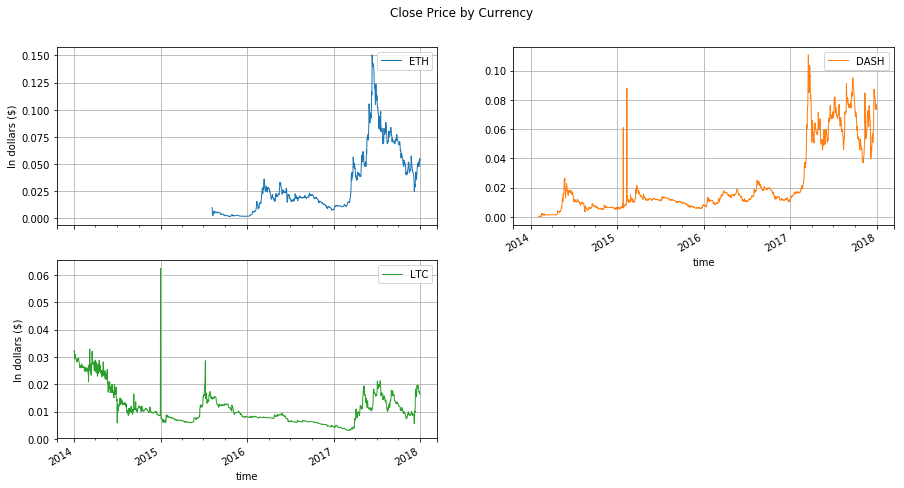

In [5]:
# plot price series
kw = dict(figsize=(15,8), grid=True, subplots=True, layout=(2,2), linewidth=1)
axs = prices.plot(**kw)
[ax.set_ylabel('In dollars ($)') for ax in axs.flat[::2]]
plt.suptitle('Close Price by Currency', y=0.95);

In [6]:
# table hurst with entire series
hurst_methods = [
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DSOD')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='RS')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DMA')),
]
hurst_table = pd.concat(hurst_methods, axis=1)
hurst_table.columns = ['DSOD', 'RS', 'DMA']
hurst_table

/Users/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:189: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


,DSOD,RS,DMA
ETH,0.431509,0.607785,0.520548
DASH,0.170188,0.578141,0.297084
LTC,0.080529,0.537747,0.319900


In [7]:
# the same methodology as shown in the paper.
roll_days = 200
roll_prices = prices.rolling(roll_days)
summary = [
    roll_prices.apply(lambda s: hurst_exponent(s, method='RS')),
    roll_prices.apply(lambda s: hurst_exponent(s, method='DSOD')),
    ]
roll_hurst = pd.concat(summary, axis=1, keys=['RS', 'DSOD'])
roll_hurst = roll_hurst.swaplevel(axis=1)\
                       .asfreq(roll_hurst.index.inferred_freq)\
                       .sort_index(axis=1, level=0)

/Users/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """
/Users/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


In [8]:
roll_hurst[::10].tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2017-11-21  0.407207  0.499267  0.370476  0.622994  0.463191  0.548170
2017-12-01  0.395354  0.533850  0.364881  0.623306  0.486269  0.520246
2017-12-11  0.449758  0.518939  0.395707  0.575868  0.481994  0.537818
2017-12-21  0.419262  0.562457  0.389706  0.521970  0.623582  0.552430
2017-12-31  0.484537  0.501211  0.582951  0.485258  0.593825  0.560107

In [9]:
roll_hurst[::20].tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2017-10-12  0.601617  0.460141  0.375790  0.623797  0.441167  0.547199
2017-11-01  0.584197  0.481830  0.369125  0.644164  0.511669  0.476064
2017-11-21  0.407207  0.499267  0.370476  0.622994  0.463191  0.548170
2017-12-11  0.449758  0.518939  0.395707  0.575868  0.481994  0.537818
2017-12-31  0.484537  0.501211  0.582951  0.485258  0.593825  0.560107

In [10]:
roll_hurst[::30].tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2017-08-13  0.681594  0.634379  0.378088  0.603522  0.456833  0.542584
2017-09-12  0.624312  0.609017  0.385435  0.597959  0.459259  0.503796
2017-10-12  0.601617  0.460141  0.375790  0.623797  0.441167  0.547199
2017-11-11  0.584221  0.482491  0.361210  0.630724  0.483020  0.469824
2017-12-11  0.449758  0.518939  0.395707  0.575868  0.481994  0.537818

In [8]:
roll_hurst[::50].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2017-06-04  0.613386  0.571719  0.671706  0.643237  0.766343  0.685446   
2017-07-24  0.347396  0.536421  0.520810  0.700199  0.627303  0.656665   
2017-09-12  0.372230  0.607045  0.337837  0.627141  0.557850  0.695906   
2017-11-01  0.383531  0.608459  0.366069  0.511993  0.513691  0.703634   
2017-12-21  0.953495  0.605048  0.085168  0.544542  0.740493  0.665918   

                 LTC            
                DSOD        RS  
time                            
2017-06-04  0.831028  0.435860  
2017-07-24  0.683580  0.539914  
2017-09-12  0.612058  0.611698  
2017-11-01  0.538235  0.570800  
2017-12-21  0.778933  0.542966

In [13]:
roll_hurst[::10].mean()

DASH  DSOD    0.434428
      RS      0.532218
ETH   DSOD    0.480836
      RS      0.584932
LTC   DSOD    0.337667
      RS      0.507515
dtype: float64

In [14]:
roll_hurst[::20].mean()

DASH  DSOD    0.434057
      RS      0.530503
ETH   DSOD    0.476984
      RS      0.587111
LTC   DSOD    0.336048
      RS      0.511325
dtype: float64

In [15]:
roll_hurst[::30].mean()

DASH  DSOD    0.436666
      RS      0.533980
ETH   DSOD    0.484415
      RS      0.583498
LTC   DSOD    0.336225
      RS      0.505014
dtype: float64

In [16]:
roll_hurst[::50].mean()

DASH  DSOD    0.431478
      RS      0.538779
ETH   DSOD    0.490442
      RS      0.580207
LTC   DSOD    0.331634
      RS      0.506937
dtype: float64

In [24]:
roll_hurst[::10].median()

DASH  DSOD    0.508278
      RS      0.537405
ETH   DSOD    0.477579
      RS      0.597868
LTC   DSOD    0.399215
      RS      0.501821
dtype: float64

In [25]:
roll_hurst[::20].median()

DASH  DSOD    0.508551
      RS      0.539581
ETH   DSOD    0.456625
      RS      0.598483
LTC   DSOD    0.399092
      RS      0.511653
dtype: float64

In [26]:
roll_hurst[::30].median()

DASH  DSOD    0.503527
      RS      0.544221
ETH   DSOD    0.484489
      RS      0.598574
LTC   DSOD    0.398328
      RS      0.488737
dtype: float64

In [10]:
roll_hurst[::50].median()

BTC   DSOD    0.563807
      RS      0.596773
DASH  DSOD    0.420299
      RS      0.455421
ETH   DSOD    0.511467
      RS      0.650846
LTC   DSOD    0.594432
      RS      0.573963
dtype: float64

In [20]:
roll_hurst[::10].mean(level=0, axis=1);

In [21]:
roll_hurst[::20].mean(level=0, axis=1);

In [22]:
roll_hurst[::30].mean(level=0, axis=1);

In [23]:
roll_hurst[::50].mean(level=0, axis=1);

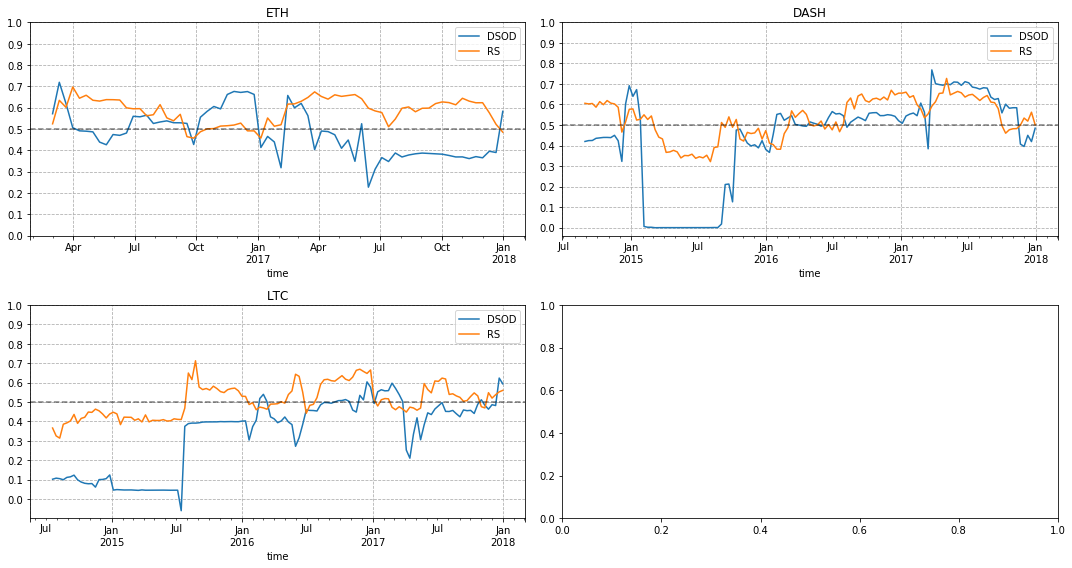

In [27]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::10].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

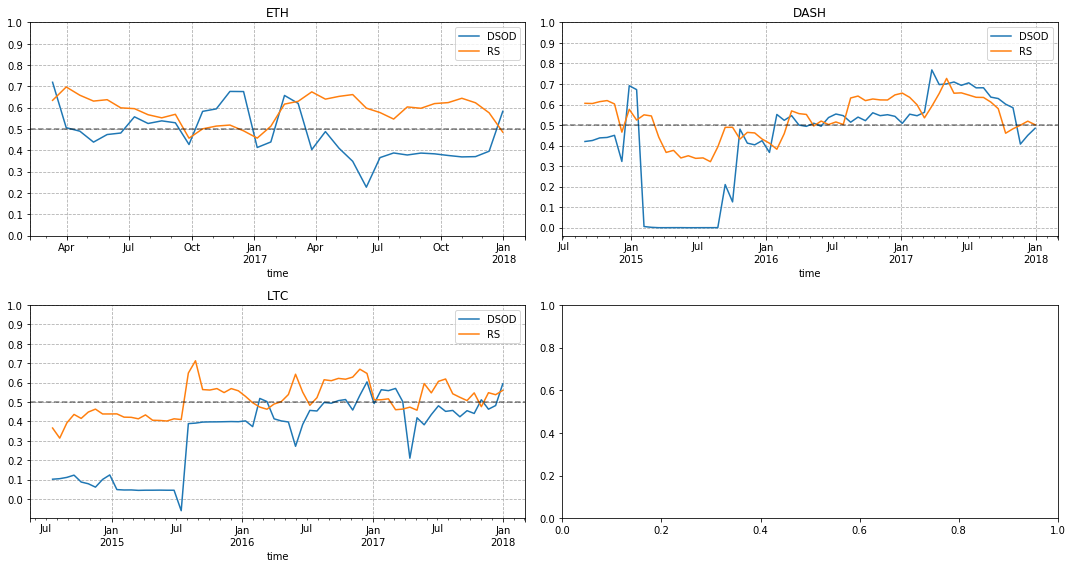

In [28]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::20].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

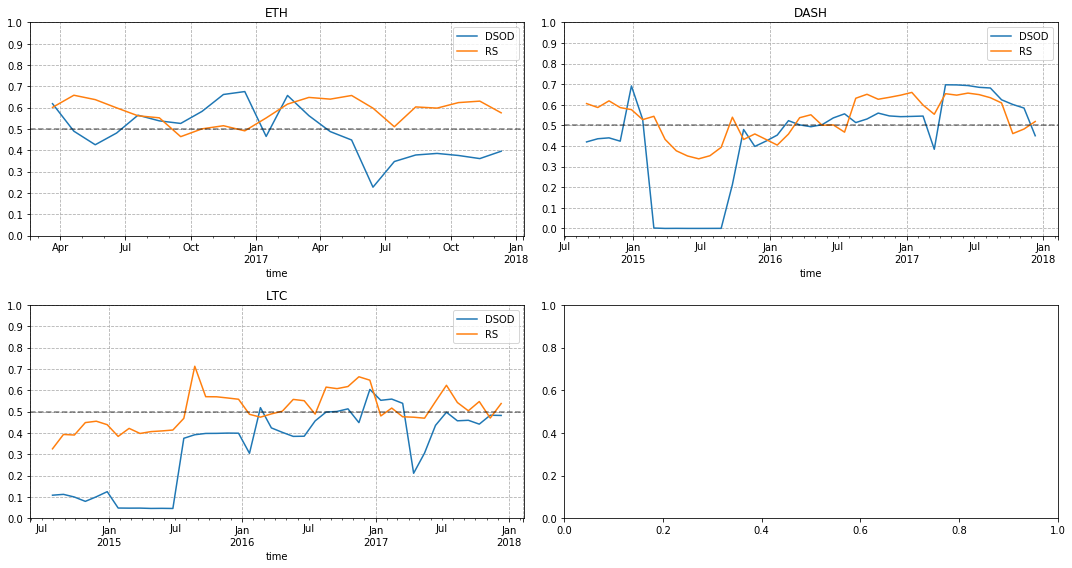

In [29]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::30].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

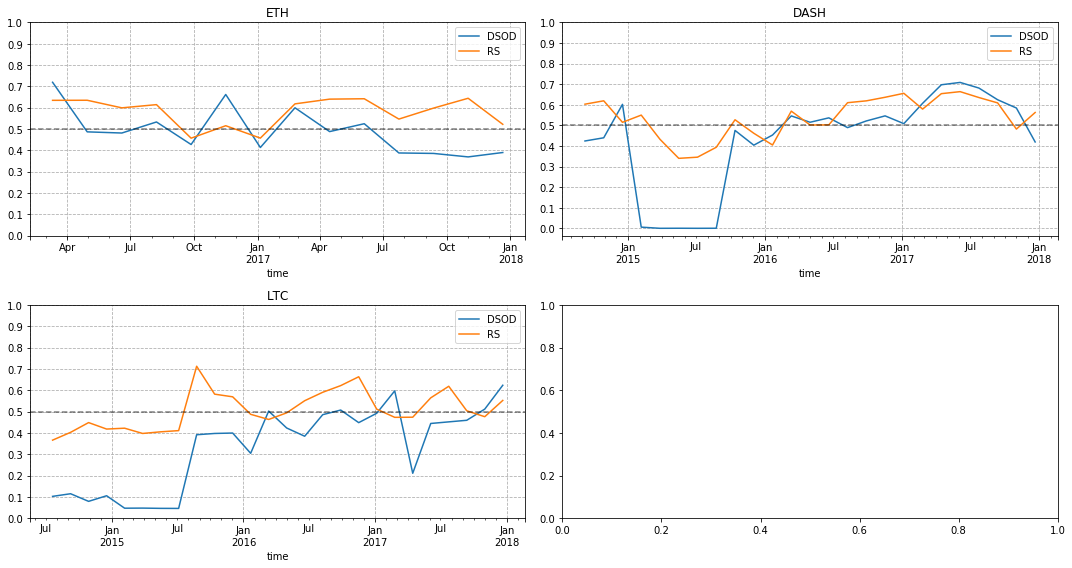

In [30]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::50].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [31]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(10).mean()
ma_roll_hurst.tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2017-12-27  0.465107  0.569015  0.405667  0.508751  0.617528  0.551944
2017-12-28  0.467723  0.569602  0.426944  0.509207  0.618520  0.555119
2017-12-29  0.470460  0.566878  0.446838  0.506163  0.617075  0.558481
2017-12-30  0.473922  0.561298  0.466560  0.503720  0.615179  0.558729
2017-12-31  0.480450  0.555174  0.485885  0.500049  0.612203  0.559497

In [32]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(20).mean()
ma_roll_hurst.tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2017-12-27  0.454053  0.554945  0.394240  0.522321  0.576242  0.551856
2017-12-28  0.458171  0.554796  0.403206  0.520959  0.584646  0.552474
2017-12-29  0.460057  0.553746  0.411901  0.518321  0.588084  0.553043
2017-12-30  0.461966  0.553558  0.420625  0.514997  0.592848  0.553446
2017-12-31  0.463705  0.552672  0.429987  0.510466  0.598440  0.554561

In [33]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(30).mean()
ma_roll_hurst.tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2017-12-27  0.437553  0.543247  0.391145  0.549644  0.547995  0.548040
2017-12-28  0.440835  0.544997  0.397851  0.546122  0.551267  0.548735
2017-12-29  0.444023  0.545908  0.404717  0.542000  0.554989  0.549013
2017-12-30  0.446709  0.545375  0.412056  0.537816  0.558435  0.549484
2017-12-31  0.449682  0.544288  0.419325  0.533215  0.562020  0.550813

In [34]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(50).mean()
ma_roll_hurst.tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2017-12-27  0.436751  0.526810  0.382232  0.579365  0.523893  0.531430
2017-12-28  0.434701  0.527905  0.386489  0.577422  0.526504  0.533399
2017-12-29  0.432761  0.528607  0.390953  0.574566  0.528741  0.535581
2017-12-30  0.430795  0.528874  0.395377  0.571590  0.531102  0.537201
2017-12-31  0.428801  0.529249  0.399812  0.568680  0.533319  0.539006

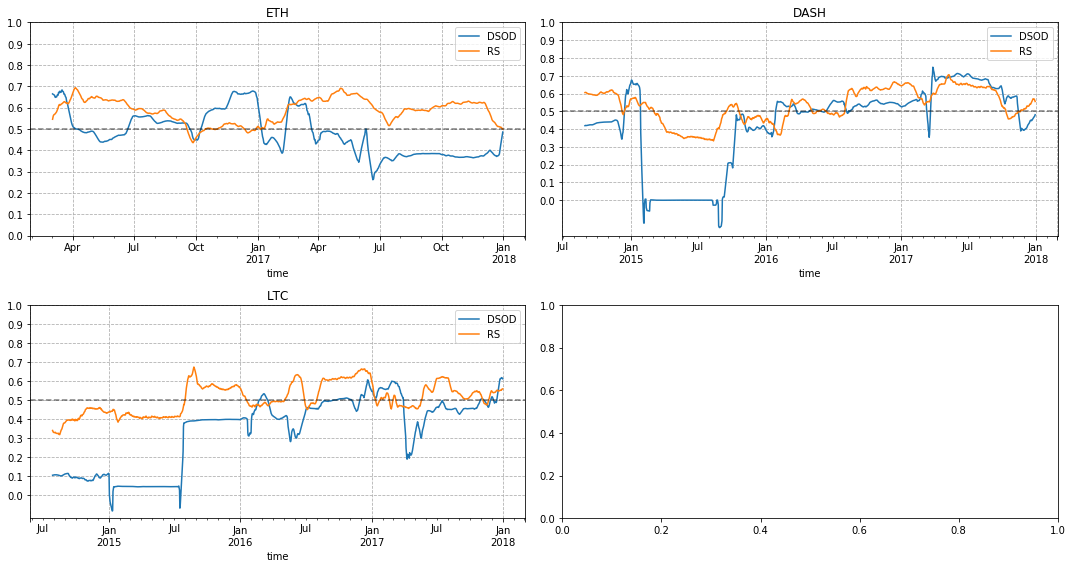

In [35]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(10).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

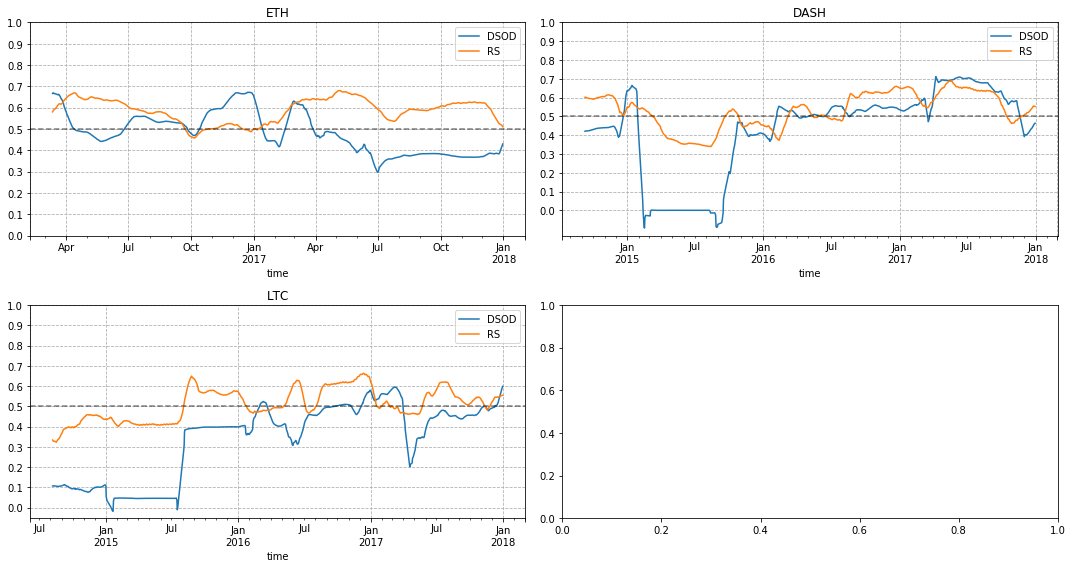

In [36]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(20).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

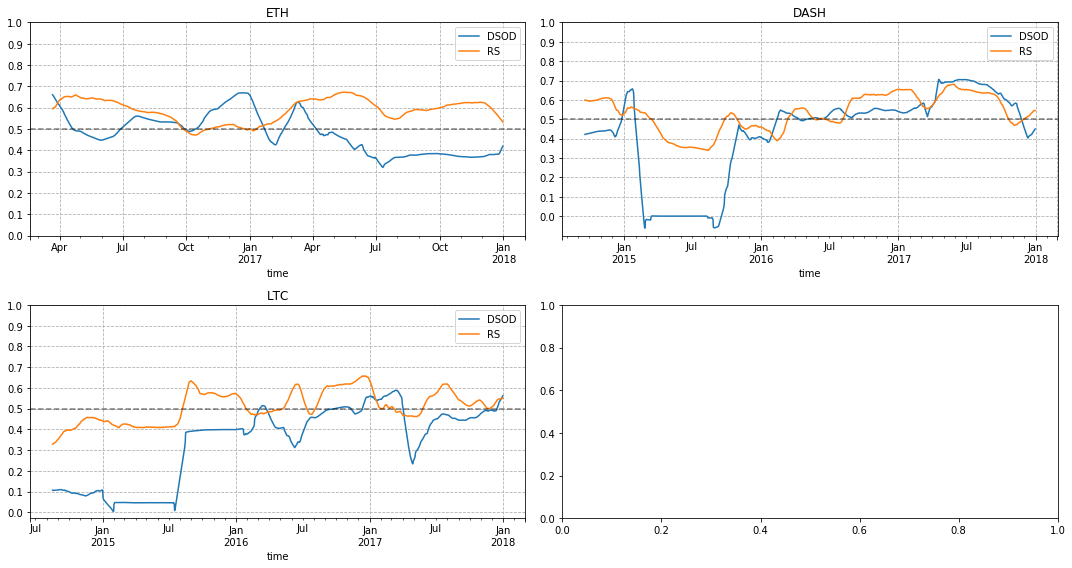

In [37]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(30).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

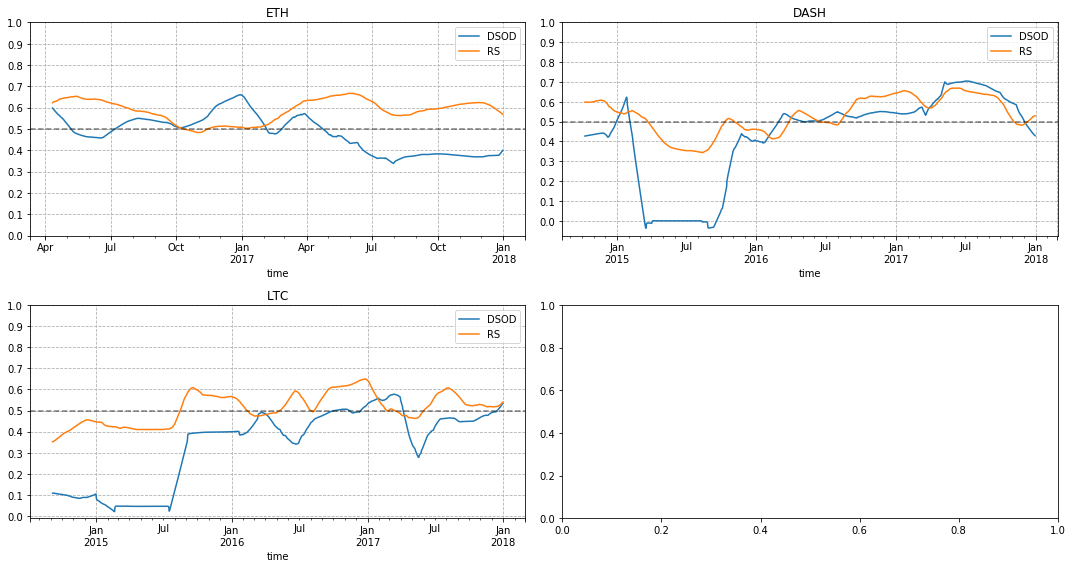

In [38]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(50).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

# REFERENCES

- Caporale, G. M., Gil-Alana, L., & Plastun, A. (2017). Persistence in the Cryptocurrency Market. https://www.sciencedirect.com/science/article/pii/S0275531917309200
- H.E. Hurst, 1951, “Long-term storage of reservoirs: an experimental study,” Transactions of the American Society of Civil Engineers, Vol. 116, pp. 770-799.
- Bo Qian, Khaled Rasheed, 2004, “Hurst Exponent and financial market predictability,” IASTED conference on “Financial Engineering and Applications”(FEA 2004), pp. 203-209,
- Mandelbrot, Benoit B., 2004, “The (Mis)Behavior of Markets, A Fractal View of Risk, Ruin and Reward,” Basic Books, 2004.
